# Explore the data
We'll be working with 3D MRI brain scans from the public Medical Segmentation Decathlon challenge project. This is an incredibly rich dataset that provides us with labels associated with each point (voxel) inside a 3D representation of a patient's brain. Ultimately, we will train a neural network to make three-dimensional spatial segmentation predictions for common brain disorders.



In [3]:
# Import all the necessary packages
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
import keras.backend as K
sns.set_style('darkgrid')

Using TensorFlow backend.


## Loading Images of the brain


In [4]:
#  the image path and load the data
image_path = "BraTS-Data/imagesTr/BRATS_001.nii.gz"
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


## Extract the data as a numpy array

In [5]:
# Extract data as numpy ndarray
image_data = image_obj.get_fdata()
type(image_data)

numpy.ndarray

In [6]:
# Get the image shape and print it out
height, width, depth, channels = image_data.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}, channels:{channels}")

The image object has the following dimensions: height: 240, width:240, depth:155, channels:4


As you can see these "image objects" are actually 4 dimensional! With the exploratory steps below you'll get a better sense of exactly what each of these dimensions represents.

## Visualize the data
The "depth" listed above indicates that there are 155 layers (slices through the brain) in every image object. To visualize a single layer, run the cell below. Note that if the layer is one of the first or the last (i near 0 or 154), you won't find much information and the screen will be dark. Run this cell multiple times to look at different layers.

The following code grabs a random layer but you can select a specific layer by choosing a value for i from 0 to 154. You can also change which channel you're looking at by changing the channel variable.


Plotting Layer 28 Channel 2 of Image


(-0.5, 239.5, 239.5, -0.5)

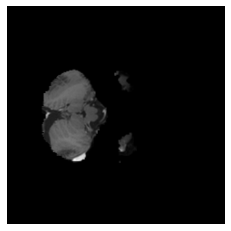

In [8]:
# Select random layer number
maxval = 154
i = np.random.randint(0, maxval)
# a channel to look at
channel = 2
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.imshow(image_data[:, :, i, channel], cmap='gray')
plt.axis('off')

## Interactive exploration
Another way to visualize this dataset is by using IPython Widgets to allow for an interactive exploration of the data.

Across different layers of the data. Move the slider to explore different layers. Change the channel value to explore different channels. See if you can tell which layer corresponds to the top of the brain and which corresponds to the bottom!


In [9]:
# function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(image_data[:, :, layer, channel], cmap='gray')
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer


interact(explore_3dimage, layer=(0, image_data.shape[2] - 1))

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

<function __main__.explore_3dimage(layer)>

## Explore the data labels
Here we'll read in a new dataset containing the labels for the MRI scan you loaded above.

In [10]:
#  the data path and load the data
label_path = "./BraTS-Data/labelsTr/BRATS_001.nii.gz"
label_obj = nib.load(label_path)
type(label_obj)

nibabel.nifti1.Nifti1Image

## Extract the data as a numpy array
Run the next cell to extract the data labels using the get_fdata() method of the image object

In [12]:
# Extract data labels
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [13]:
# Extract and print out the shape of the labels data
height, width, depth = label_array.shape
print(f"Dimensions of labels data array height: {height}, width: {width}, depth: {depth}")
print(f'With the unique values: {np.unique(label_array)}')
print("""Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor""")

Dimensions of labels data array height: 240, width: 240, depth: 155
With the unique values: [0. 1. 2. 3.]
Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor


## Visualize the labels for a specific layer
The code below shows a single layer and you can set i to any value from 0 to 154 to look at a different layer.

Note that if you choose a layer near 0 or 154 there might not be much to look at in the images.

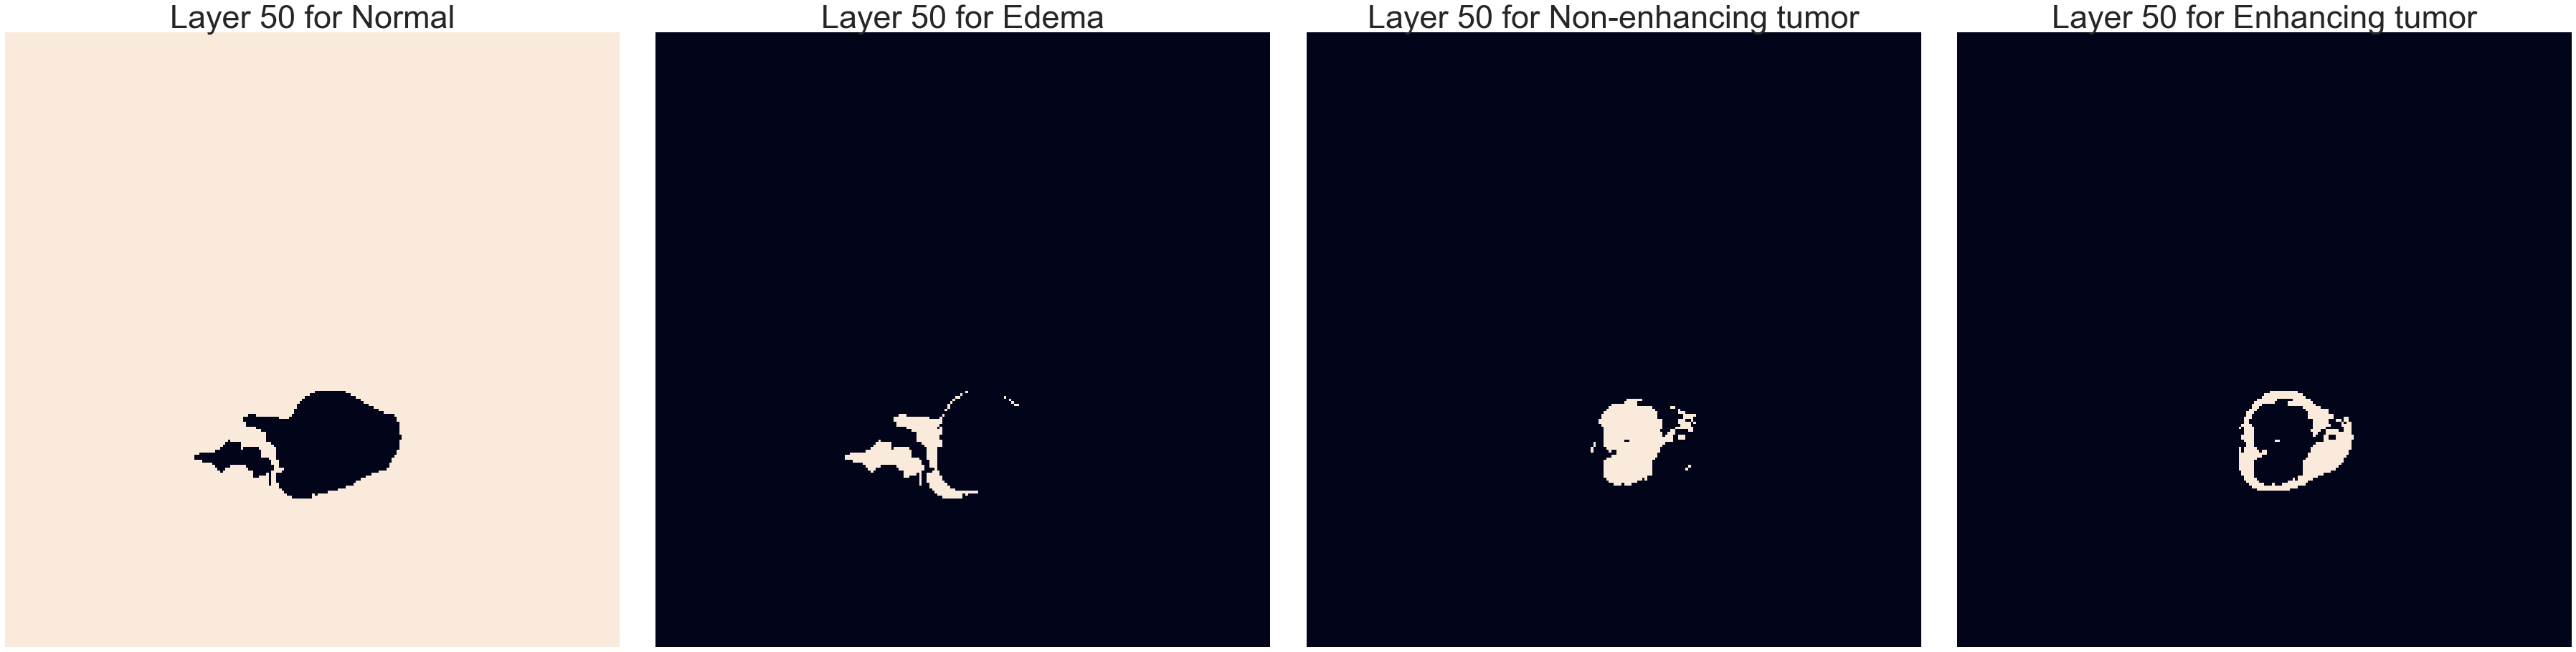

In [14]:
# single layer for plotting
layer = 50
# dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}
# Set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

## Interactive visualization across layers


In [15]:
#  button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info', 
    
)
#  layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)

    
#  function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

# interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

In [17]:
dice_coef = dice_coefficient
dice_coef_loss = dice_coefficient_loss

## Now we need to extract subsection MRI data, which is in notebook called extract_subsection.ipynb